![Multi-layer Graph Convolutional Network (GCN) with first-order filters,来源:http://tkipf.github.io/graph-convolutional-networks/](images/gcn_web.png)

# 1. GCN是什么

图卷积神经网络(Graph Convolution Networks, GCN)跟CNN一样是特征提取的工具，CNN在处理规则数据结构(如图片等)方面非常强大。

![图像矩阵示意图（Euclidean Structure）](images/cnn_sample.jpg)

但是在现实世界中，很多数据结构是不规则的，典型的就是图结构，如社交网络、知识图谱等，GNN就比较擅长处理这类数据。

![社交网络拓扑示意（Non Euclidean Structure）](images/social_non_struct.jpg)

本文主要通过一个完整的GCN对论文进行分类的例子，来展示GCN的工作过程和原理。

这里我们使用的Cora数据集，该数据集由2708篇论文的特征、分类以及它们之间引用关系的5429条边组成，这些论文的类型被划分为7个类别:Case\_Based、Genetic\_Algorithms、Neural\_Networks、Probabilistic\_Methods、Reinforcement\_Learning、Rule\_Learning、Theory。

最终实现的目标是，输入一篇论文的特征，就可以输出该论文属于哪个分类。

# 2. 数据集-Cora Dataset

## 2.1 下载地址

https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

## 2.2 数据内容

Cora Dataset是对Machine Learning Paper进行分类的数据集，它包含三个文件:

-- README: 对数据集的介绍;

-- cora.cites: 论文之间的引用关系图。文件中每行包含两个Paper ID， 第一个ID是被引用的Paper ID； 第二个是引用的Paper ID。格式如下: <ID of cited paper> <ID of citing paper>

-- cora.content: 包含了2708篇Paper的信息，每行的数据格式如下: <paper_id> <word_attributes>+ <class_label>。paper id是论文的唯一标识；word_attributes是是一个维度为1433的词向量，词向量的每个元素对应一个词，0表示该元素对应的词不在Paper中，1表示该元素对应的词在Paper中。class_label是论文的类别，每篇Paper被映射到如下7个分类之一: Case_Based、Genetic_Algorithms、Neural_Networks、Probabilistic_Methods、Reinforcement_Learning、Rule_Learning、Theory。
    
先看看Cora Dataset中的数据是什么样的...

In [77]:
import pandas as pd
import numpy as np

# 导入数据：分隔符为Tab
raw_data_content = pd.read_csv('data/cora/cora.content',sep = '\t',header = None)

# [2708 * 1435]
(row, col) = raw_data_content.shape
print("Cora Contents’s Row: {}, Col: {}".format(row, col))

print("=============================================")

# 每行是1435维的向量，第一维是论文的ID，最后一维是论文的Label
raw_data_sample = raw_data_content.head(3)
features_sample =raw_data_sample.iloc[:,1:-1]
labels_sample = raw_data_sample.iloc[:, -1]
labels_onehot_sample = pd.get_dummies(labels_sample)


print("features:{}".format(features_sample))

print("=============================================")

print("labels:{}".format(labels_sample))


print("=============================================")

print("labels one hot:{}".format(labels_onehot_sample))


Cora Contents’s Row: 2708, Col: 1435
features:   1     2     3     4     5     6     7     8     9     10    ...  1424  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   

   1425  1426  1427  1428  1429  1430  1431  1432  1433  
0     0     0     1     0     0     0     0     0     0  
1     0     1     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  

[3 rows x 1433 columns]
labels:0           Neural_Networks
1             Rule_Learning
2    Reinforcement_Learning
Name: 1434, dtype: object
labels one hot:   Neural_Networks  Reinforcement_Learning  Rule_Learning
0                1                       0              0
1                0                       0              1
2                0                       1              0


In [73]:
raw_data_cites = pd.read_csv('data/cora/cora.cites',sep = '\t',header = None)

# [5429 * 2]
(row, col) = raw_data_cites.shape

print("Cora Cites’s Row: {}, Col: {}".format(row, col))

print("=============================================")

raw_data_cites_sample = raw_data_cites.head(10)

print(raw_data_cites_sample)

print("=============================================")

# raw_data_cites.head(10).values.flatten().tolist()


# Convert Cite to adj matrix
idx = np.array(raw_data_content.iloc[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}


edge_indexs = np.array(list(map(idx_map.get, raw_data_cites.values.flatten())), dtype=np.int32)
edge_indexs = edge_indexs.reshape(raw_data_cites.shape)
adjacency = sp.coo_matrix((np.ones(len(edge_indexs)),
            (edge_indexs[:, 0], edge_indexs[:, 1])),
            shape=(edge_indexs.shape[0], edge_indexs.shape[0]), dtype="float32")

print(adjacency)

Cora Cites’s Row: 5429, Col: 2
           0        1
0         35     1033
1         35   103482
2         35   103515
3         35  1050679
4         35  1103960
...      ...      ...
5424  853116    19621
5425  853116   853155
5426  853118  1140289
5427  853155   853118
5428  954315  1155073

[5429 rows x 2 columns]
  (163, 402)	1.0
  (163, 659)	1.0
  (163, 1696)	1.0
  (163, 2295)	1.0
  (163, 1274)	1.0
  (163, 1286)	1.0
  (163, 1544)	1.0
  (163, 2600)	1.0
  (163, 2363)	1.0
  (163, 1905)	1.0
  (163, 1611)	1.0
  (163, 141)	1.0
  (163, 1807)	1.0
  (163, 1110)	1.0
  (163, 174)	1.0
  (163, 2521)	1.0
  (163, 1792)	1.0
  (163, 1675)	1.0
  (163, 1334)	1.0
  (163, 813)	1.0
  (163, 1799)	1.0
  (163, 1943)	1.0
  (163, 2077)	1.0
  (163, 765)	1.0
  (163, 769)	1.0
  :	:
  (2228, 1093)	1.0
  (2228, 1094)	1.0
  (2228, 2068)	1.0
  (2228, 2085)	1.0
  (2694, 2331)	1.0
  (617, 226)	1.0
  (422, 1691)	1.0
  (2142, 2096)	1.0
  (1477, 1252)	1.0
  (1485, 1252)	1.0
  (2185, 2109)	1.0
  (2117, 2639)	1.0
  (121

# 3. 构造训练集、测试集和验证集

这里使用[0, 150)个数据作为训练集合，[150, 500)个数据作为验证集，[500, 2708)个数据作为测试集，实现上使用掩码(train_mask、val_mask、test_mask)的形式来区分训练集、验证集和测试集。


In [78]:
train_index = np.arange(150)
val_index = np.arange(150, 500)
test_index = np.arange(500, 2708)

train_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)
val_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)
test_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)

train_mask[train_index] = True
val_mask[val_index] = True
test_mask[test_index] = True

# 4. GCN核心网络模型

图(Graph)其实数据结构中最重要的概念之一，对，没错，图神经网的图(Graph)跟数据结构中的图(Graph)是一回事。假设神经网络的输入图(Graph)包含N个节点(Node)，每个节点有d个特征，则所有这些节点的特征组成一个Nxd维的矩阵X；两个节点间的邻接关系组成一个NxN的邻接矩阵A(adjacency),则X和A就构成了图神经网络的输入。

## 4.1 核心公式：

GCN神经网络相邻两层之间传播的核心公式如下：

$$H^{l+1}=\sigma\left(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)}\right) \tag{1}$$

其中：

$\tilde{A} = A + I$是图G的邻接矩阵加上自连接，I是单位矩阵；

$\tilde{D}$是度矩阵(Degree Matrix), 计算公式为：$\tilde{D}_{i i}=\sum_{j} \tilde{A}_{i j}$；

H是每一层的特征；

W是神经网络的待训练的权重参数；

$\sigma$是激活函数，常用的激活函数有softmax、relu等；

我们先看下GCN网络的传播过程，再反过来看公式中详细含义。

## 4.2 网络传播过程

如下所示的5个Node组成的无向图的图结构。

![](images/graph.png)

它对应的邻接矩阵A为：

$$
A = \left[ \begin{matrix} 0 & 1 & 0 & 0 & 1\\ 1 & 0 & 1 & 1 & 0 \\ 0 & 1 & 0 & 1 & 0 \\ 0 & 1 & 1 & 0 & 1 \\ 1 & 0 & 0 & 1 & 0 \end{matrix} \right]
$$

在邻接矩阵基础上加上自环，即与单位矩阵I相加，得到：

$$
\tilde{A} = \left[ \begin{matrix} 1 & 1 & 0 & 0 & 1\\ 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 \\ 1 & 0 & 0 & 1 & 1 \end{matrix} \right]
$$

简单期间，这里假设每个Graph中每个Node的特征都是一维的，$X=[1, 2, 3, 4, 5]^T$,

$$ 
\tilde{A} * X = \left[ \begin{matrix} 1 * 1 + 1 * 2 + 0 * 3 + 0 * 4 + 1 * 5 \\ 1 * 1 + 1 * 2 + 1 * 3 + 1 * 4 + 0 * 5 \\ 0 * 1 + 1 * 2 + 1 * 3 + 1 * 4 + 0 * 5 \\ 0 * 1 + 1 * 2 + 1 * 3 + 1 * 4 + 1 * 5 \\ 1 * 1 + 0 * 2 + 0 * 3 + 1 * 4 + 1 * 5 \\ \end{matrix} \right]
$$

从上式看到了什么，对，就是**各个节点都将与其一阶相邻节点的信息融合到自己的节点中，这也是公式(1)的本质所在。神经网络传播的过程，实际上就是图(Graph)中各个节点(Node)不断聚合邻居节点信息的过程。** 通过两次连乘$\tilde{A} * \tilde{A} * X$也就实现各个Node融合自己二阶邻居节点的信息。

到这里我们应该就可以理解**为什么要将邻接矩阵加上单位矩阵**。

> 因为邻接矩阵的对角线的值都是0，所以如果用邻接矩阵直接与特征矩阵相乘，就将节点自身的信息丢失了。所以为了保留节点(Node)的自身特征，需要将邻接矩阵加上单位矩阵。

既然$\tilde{A} * X$就可以实现图网络中的信息聚合，**那么$\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$ 是什么意思？**

这里只从直觉上说明这个问题，(事实上，我还没有来得及去详细推导公式，后续有时间补上，嘿嘿)

> 假设节点A的邻居只有B，为了对A进行信息聚合，最直接的方法就是平均贡献，即： New_A = 0.5* A + 0.5 * B，这样的做法看起来很合理，但是如果B的邻居非常多(极端情况是，它与图Graph上的所有其它节点都有连接)，经过特征聚合之后，图(Graph)上许多的特征就会非常相似，因此需要考虑节点(Node)的度，不要让度过大的节点(Node)贡献过大。


两层的GCN网络实现如下:

In [24]:
from __future__ import print_function

import tensorflow as tf

class GraphConvolution(tf.keras.layers.Layer):
    """Basic graph convolution layer as in https://arxiv.org/abs/1609.02907"""
    def __init__(self, units, support=1,
                 activation=None,
                 use_bias=True
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                ):
        
        super(GraphConvolution, self).__init__()
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        
        self.supports_masking = True

        self.support = support
        assert support >= 1

    def build(self, input_shapes):
        features_shape = input_shapes[0]
        assert len(features_shape) == 2
        input_dim = features_shape[1]

        self.kernel = self.add_weight(shape = (input_dim * self.support, self.units),
                                      initializer = self.kernel_initializer,
                                      name = 'kernel',
                                      regularizer = self.kernel_regularizer)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                       regularizer = self.kernel_regularizer)
        else:
            self.bias = None
            
        self.built = True

    def call(self, inputs, mask=None):
        features = inputs[0]
        basis = inputs[1:]

        supports = list()
        for i in range(self.support):
            supports.append(K.dot(basis[i], features))
        supports = K.concatenate(supports, axis=1)
        output = K.dot(supports, self.kernel)

        if self.bias:
            output += self.bias
            
        return self.activation(output)

# 5. 网络训练过程

## 5.1 准备训练数据

数据处理的细节前面都大概提过，这里需要注意的是，在数据处理的过程中，还需要对每个Node的Feature做归一化处理。

In [3]:
from graph import GraphConvolutionLayer, GraphConvolutionModel
from dataset import CoraData

import time
import tensorflow as tf
import matplotlib.pyplot as plt

dataset = CoraData()
features, labels, adj, train_mask, val_mask, test_mask = dataset.data()

graph = [features, adj]

Process data ...
Loading cora dataset...
Dataset has 2708 nodes, 2708 edges, 1433 features.


## 5.2 Loss计算

Loss函数中，只对训练数据(train_mask为True)进行Loss计算。

In [4]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss(model, x, y, train_mask, training):

    y_ = model(x, training=training)

    test_mask_logits = tf.gather_nd(y_, tf.where(train_mask))
    masked_labels = tf.gather_nd(y, tf.where(train_mask))

    return loss_object(y_true=masked_labels, y_pred=test_mask_logits)


def grad(model, inputs, targets, train_mask):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, train_mask, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## 5.3 实际训练过程 

In [12]:
def test(mask):
    logits = model(graph)

    test_mask_logits = tf.gather_nd(logits, tf.where(mask))
    masked_labels = tf.gather_nd(labels, tf.where(mask))

    ll = tf.math.equal(tf.math.argmax(masked_labels, -1), tf.math.argmax(test_mask_logits, -1))
    accuarcy = tf.reduce_mean(tf.cast(ll, dtype=tf.float64))

    return accuarcy

model = GraphConvolutionModel()

optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, decay=5e-5)

# 记录过程值，以便最后可视化
train_loss_results = []
train_accuracy_results = []
train_val_results = []
train_test_results = []

num_epochs = 200

for epoch in range(num_epochs):

    loss_value, grads = grad(model, graph, labels, train_mask)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    accuarcy = test(train_mask)
    val_acc = test(val_mask)
    test_acc = test(test_mask)

    train_loss_results.append(loss_value)
    train_accuracy_results.append(accuarcy)
    train_val_results.append(val_acc)
    train_test_results.append(test_acc)

    print("Epoch {} loss={} accuracy={} val_acc={} test_acc={}".format(epoch, loss_value, accuarcy, val_acc, test_acc))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0 loss=1.9472886323928833 accuracy=0.4066666666666667 val_acc=0.3142857142857143 test_acc=0.2817028985507246
Epoch 1 loss=1.9314587116241455 accuracy=0.4866666666666667 val_acc=0.3742857142857143 test_acc=0.33106884057971014
Epoch 2 loss=1.9133251905441284 accuracy=0.5 val_acc=0.38571428571428573 test_acc=0.34782608695652173
Epoch 3 loss=1.8908278942108154 accuracy=0.5266666666666666 val_acc=0.3942857142857143 test_acc=0.3496376811594203
Epoch 4 loss=1.8662141561508179 accuracy=0.5533333333333333 

Epoch 72 loss=0.07684874534606934 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6100543478260869
Epoch 73 loss=0.0733552798628807 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6096014492753623
Epoch 74 loss=0.07009640336036682 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6100543478260869
Epoch 75 loss=0.06705603748559952 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6096014492753623
Epoch 76 loss=0.06421645730733871 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6091485507246377
Epoch 77 loss=0.06155867129564285 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6086956521739131
Epoch 78 loss=0.05906983092427254 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6086956521739131
Epoch 79 loss=0.05673719570040703 accuracy=1.0 val_acc=0.6914285714285714 test_acc=0.6086956521739131
Epoch 80 loss=0.054548606276512146 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6091485507246377
Epoch 81 loss=0.052494876086711884 accuracy=1.0 val_acc=0.6885714285714286 test_ac

Epoch 153 loss=0.011655798181891441 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 154 loss=0.011505785398185253 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 155 loss=0.011358906514942646 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 156 loss=0.011214920319616795 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 157 loss=0.011073877103626728 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 158 loss=0.010935710743069649 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6005434782608695
Epoch 159 loss=0.010800261981785297 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6000905797101449
Epoch 160 loss=0.010667545720934868 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6000905797101449
Epoch 161 loss=0.01053738035261631 accuracy=1.0 val_acc=0.6885714285714286 test_acc=0.6000905797101449
Epoch 162 loss=0.010409791953861713 accuracy=1.0 val_acc=0.688571

可以看到，经过200次迭代后，最终GCN网络在验证集上的准确率达到70%左右，在测试集中的Accuracy达到了60%左右。

##  5.4 训练过程可视化

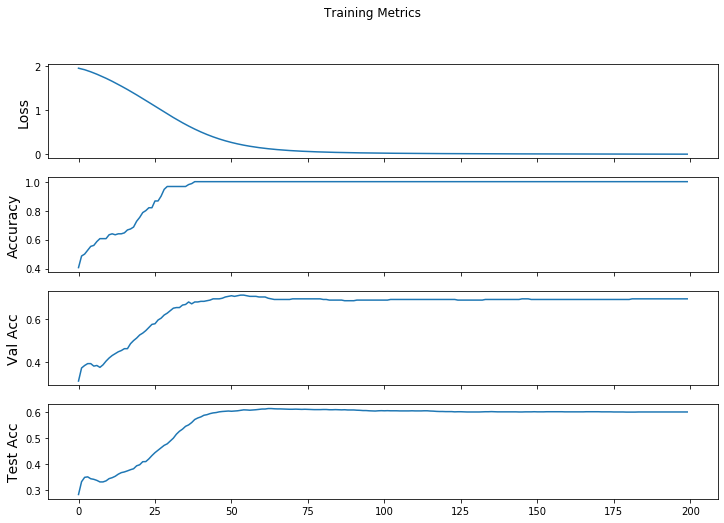

In [13]:
# 训练过程可视化
fig, axes = plt.subplots(4, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(train_accuracy_results)

axes[2].set_ylabel("Val Acc", fontsize=14)
axes[2].plot(train_val_results)

axes[3].set_ylabel("Test Acc", fontsize=14)
axes[3].plot(train_test_results)

plt.show()